In [2]:
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import datetime
import os
import subprocess

from os.path import exists

import random
from resiliparse.parse.html import HTMLTree
from resiliparse.parse.encoding import detect_encoding
from resiliparse.extract.html2text import extract_plain_text
from get_training_query_term_recall import calculate_doc_term_recall
from passage_extraction_util import passage_calculate_doc_term_recall

In [3]:
c = 0

with open('./reddit-tomt-submissions.jsonl') as f, gzip.open('./reddit-tomt-submissions-with-links.jsonl.gz', 'wt') as output_file:
    for l in tqdm(f):
        l = json.loads(l)
        if 'links_on_answer_path' in l and len(l['links_on_answer_path']) > 0:
            output_file.write(json.dumps(l) + '\n')


1279425it [04:13, 5045.19it/s]


In [3]:
with gzip.open('./reddit-tomt-submissions-with-links.jsonl.gz') as f:
    entries = []
    for l in tqdm(f):
        l = json.loads(l)
        del l['comments']
        entries.append(l)


326458it [01:50, 2944.07it/s]


In [4]:
def clean_urls(urls):
    ret = []
    for url in urls:
        url = url.split(')')[0]
        url = url.split('(')[-1]
        ret.append(url)        
    return ret
        
assert ['https://www.reddit.com/r/woahdude/comments/66wqhv/true_cyan_color_illusion/'] == clean_urls(['https://www.reddit.com/r/woahdude/comments/66wqhv/true_cyan_color_illusion/'])
assert ['https://www.reddit.com/r/woahdude/comments/66wqhv/true_cyan_color_illusion/'] == clean_urls(['https://www.reddit.com/r/woahdude/comments/66wqhv/true_cyan_color_illusion/)'])
assert ['https://www.reddit.com/r/woahdude/comments/66wqhv/true_cyan_color_illusion/'] == clean_urls(['[text](https://www.reddit.com/r/woahdude/comments/66wqhv/true_cyan_color_illusion/)nochmehrtext'])

In [5]:
def get_htmls(entry):
    links = clean_urls(entry['links_on_answer_path'])
    
    ret = dict()
    for link in links:
        html_file = f"websites/{link.split('://')[-1]}"
        if exists(html_file):
            for suffix in ['','/index.html']:
                if os.path.isfile(html_file + suffix):
                    ret[link] = html_file + suffix
                    break
            if link not in ret:
                raise ValueError('todo')
        
    return ret

assert get_htmls({'links_on_answer_path': ['http://www.louissachar.com/Wayside.htm']}) == {'http://www.louissachar.com/Wayside.htm': 'websites/www.louissachar.com/Wayside.htm'}
assert get_htmls({'links_on_answer_path': ['http://www.youtube.com/watch?v=NU75uz0b8EU']}) == {'http://www.youtube.com/watch?v=NU75uz0b8EU': 'websites/www.youtube.com/watch?v=NU75uz0b8EU/index.html'}
assert False, 'ToDo: I remember that I saw that the parsing above does not work for xy.'

In [6]:
def download_page(reddit_entry):
    if get_htmls(reddit_entry):
        return
    
    current_directory = os.getcwd()
    links = clean_urls(reddit_entry['links_on_answer_path'])
    timestamp = int(reddit_entry['solved_utc'])
    time = datetime.datetime.utcfromtimestamp(timestamp)
    time_start = (time - datetime.timedelta(days=365)).strftime("%Y%m%d%H%M%S")
    time_end = (time + datetime.timedelta(days=365)).strftime("%Y%m%d%H%M%S")
    for link in links:
        command = [
        "docker",
        "run",
        "-v",
        f"{current_directory}/websites:/websites",
        "hartator/wayback-machine-downloader",
        "--exact-url",
        "--from",
        time_start,
        "--to",
        time_end,
        "--maximum-snapshot",
        "2",
        link
        ]
        subprocess.run(command, check=True)


In [7]:
def extract_text(html_file, return_type):
    tree = HTMLTree.parse_from_bytes(open(html_file, 'rb').read(), detect_encoding(open(html_file, 'rb').read()))
    if return_type == 'title':
        return tree.head.text
    elif return_type == 'main':
        return tree.head.text + ' ' + extract_plain_text(tree, main_content=True)
    return tree.body.text

assert extract_text('websites/www.louissachar.com/Wayside.htm', 'title') == '\nLouis Sachar —  Wayside School Book Series\n\n'
assert extract_text('websites/www.louissachar.com/Wayside.htm', 'main').startswith("\nLouis Sachar —  Wayside School Book Series\n\n \n\nTo purchase any of Louis's books visit your local bookseller or make your selection online:\n\nSideways Stories from\nWayside School\n\n\xa0\n\nWayside School\nis Falling Down\n\n\xa0\n\nWayside School\n")

In [8]:
def extract_question(entry):
    return entry['title'].split(']')[-1] + '. ' + entry['content']

In [9]:
class text_normalization():
    def stem():
        return True

    def stop():
        return True

def construct_instance_for_model_training(entry, text_type):
    target_texts = []
    question = extract_question(entry)
    for link in get_htmls(entry).values():
        target_texts.append(extract_text(link, text_type))
    input_data = [json.dumps({"queries": target_texts, "doc":{"title": question}})]
    return list(calculate_doc_term_recall(input_data, text_normalization()))

In [ ]:
from copy import deepcopy

training_method = 'title'
with open('training-data-title-06-07-2023.jsonl', 'w') as f:
    for entry in tqdm(entries):
        entry = deepcopy(entry)
        training_samples = []
        try:
            for i in construct_instance_for_model_training(entry, training_method):
                if i['term_recall']:
                    training_samples += [i]
        except:
            pass
    
        entry['training_samples'] = {'method': training_method, 'instances': training_samples}
    
        if training_samples:
            f.write(json.dumps(entry) + '\n')


  0%|▎                                                                                                   | 1201/326458 [03:57<23:08:24,  3.90it/s]

In [79]:
construct_instance_for_model_training(entries[5], 'title')

[{'doc': {'id': 1,
   'position': 1,
   'title': " A woman birthing monsters/aliens. I was re-watching Prometheus and during the c-section scene in the giant med-machine I had a little flashback to a movie or series (not sure) I saw as a child of a human woman giving birth to either monsters, mutants or aliens. It's not much to go on but the only thing i remember are a long medical table,  an orange light being cast on the table and a woman popping out what at the time I believed were aliens? It must have been an 80's early 90' production. \nThanks in advance :)\n\nEdit:  Everything had a dark atmosphere, like it was happening at night or in a dark room."},
  'term_recall': {'birth': 1.0,
   'birthing': 1.0,
   'c': 1.0,
   'scene': 1.0,
   'time': 1.0}}]

In [60]:
for entry in tqdm(entries):
    download_page(entry)

  0%|          | 43/326458 [00:41<87:13:32,  1.04it/s] 


KeyboardInterrupt: 

In [5]:
!cat ./reddit-tomt-submissions.jsonl | shuf | head -100000 > json-tomt-sample.jsonl

shuf: write error: Broken pipe
shuf: write error


In [6]:
!cat json-tomt-sample.jsonl | wc -l

100000


In [7]:
df = pd.read_json("./json-tomt-sample.jsonl", lines=True)

In [10]:
df['category'] = df.apply(lambda i: extract_category(i), axis=1)

In [11]:
df.head(2)

,hide_score,domain,author_flair_text,created_utc,solved_utc,subreddit,media_embed,secure_media_embed,chosen_answer,links_on_answer_path,...,brand_safe,mod_note,mod_reason_by,mod_reason_title,approved_at_utc,banned_at_utc,rte_mode,post_categories,visited,previous_visits
0,NaN,self.tipofmytongue,None,1557725027,1557725407,tipofmytongue,{},{},bit of a long shot but [Pocoyo](https://tvtro...,[https://tvtropes.org/pmwiki/pmwiki.php/Wester...,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,0.0,self.tipofmytongue,None,1454487496,,tipofmytongue,{},{},,[],...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None


In [12]:
df.iloc[0].to_dict()

{'all_awardings': [],
 'allow_live_comments': nan,
 'approved_at_utc': nan,
 'approved_by': nan,
 'archived': 0.0,
 'author': 'PrezyDante',
 'author_cakeday': nan,
 'author_created_utc': 1501634594.0,
 'author_flair_background_color': None,
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_template_id': nan,
 'author_flair_text': None,
 'author_flair_text_color': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_93bvfuc',
 'author_patreon_flair': 0.0,
 'author_premium': nan,
 'awarders': None,
 'banned_at_utc': nan,
 'banned_by': nan,
 'brand_safe': nan,
 'call_to_action': None,
 'can_gild': 1.0,
 'can_mod_post': 0.0,
 'category': 'KID’S SHOW',
 'chosen_answer': 'bit of a long shot but  [Pocoyo](https://tvtropes.org/pmwiki/pmwiki.php/WesternAnimation/Pocoyo)?',
 'clicked': nan,
 'comments': [{'all_awardings': [],
   'author': 'ClairieO',
   'author_created_utc': 1353317609,
   'author_flair_background_color': '',
   'author_flair_css_class': None,


In [9]:
def extract_category(tomt):
    
    return tomt.to_dict()['title'].split('[')[-1].split(']')[0]

In [13]:
df['category'].value_counts().head(20)

TOMT     25066
SONG      4770
MOVIE     4303
Song      3590
Movie     2865
2000s     2665
song      1749
2010s     1693
Video     1619
video     1422
VIDEO     1373
BOOK      1246
MUSIC     1243
Music     1145
Book      1086
movie     1077
GAME       897
tomt       714
Game       662
1990s      515
Name: category, dtype: int64

In [14]:
df[df['category'].str.contains('site')].category.value_counts()

Website                 402
website                 371
website/game              2
website/article           2
Website?                  2
                       ... 
Old websites              1
Picture/Website           1
subbreddits/websites      1
TOMT - website            1
Web site                  1
Name: category, Length: 128, dtype: int64

In [15]:
df[df['category'].str.contains('page')].category.value_counts()

Webpage                                                                                                                                                                            3
web page                                                                                                                                                                           2
webpage                                                                                                                                                                            2
Recently on the frontpage                                                                                                                                                          1
Children's book that was recently on the front page                                                                                                                                1
Reddit page                                                                                    

/home/christine/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/christine/.local/lib/python3.6/site-packages/seaborn/categorical.py:376: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-.5, len(self.plot_data) - .5, auto=None)


<AxesSubplot:xlabel='ups'>

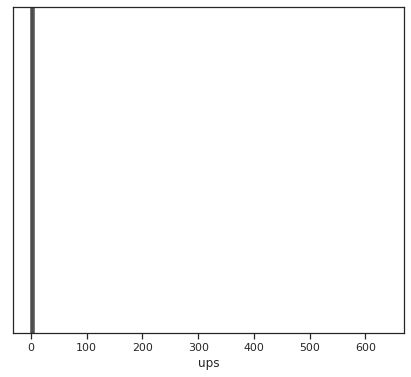

In [16]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.boxplot(df.ups)
# observation: zero or ten or more upvotes are outlayers, hence we take questions with 1-9 upvotes

<AxesSubplot:>

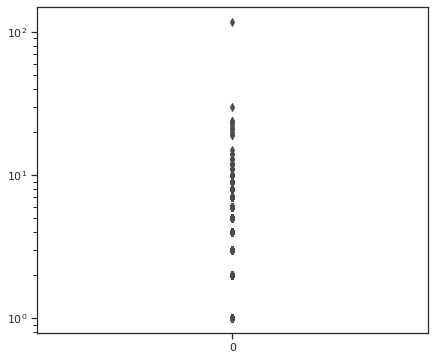

In [41]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.boxplot(df.downs)
# observation:questions with one downvote are already outlayers, hence we only take questions with zero downvotes

<AxesSubplot:>

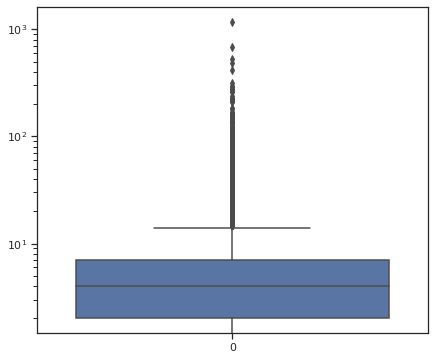

In [42]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.boxplot(df.num_comments)
# observation:questions with zero or 13 comments are already outlayers, hence we only take questions with zero downvotes

In [43]:
df.num_comments.describe()

count    100000.000000
mean          5.338720
std           8.477454
min          -1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max        1170.000000
Name: num_comments, dtype: float64

In [44]:
df.num_comments.quantile(q=0.95)

13.0

In [58]:
#select topics

#define conditions
c1 = df["solved_utc"] != ""
c2 = (df["ups"]>0) & (df["ups"]<10)
c3 = df["downs"]==0
c4 = (df["num_comments"] > 0) & (df["num_comments"]<13)

#apply conditions to dataframe
topics = df[c1 & c2 & c3 & c4]

#select samples by category
books = topics[topics["category"].isin(["BOOK", "Book"])].sample(250)
movies = topics[topics["category"].isin(["MOVIE", "Movie", "movie"])].sample(250)
websites = topics[topics["category"].isin(["Website", "website"])] #less then 250 elements, so all are taken
songs = topics[topics["category"].isin(["SONG", "Song", "song", "MUSIC", "Music"])].sample(250)

In [74]:
books.to_json("./books.json", orient = "records", lines = True)
movies.to_json("./movies.json", orient = "records", lines = True)
websites.to_json("./websites.json", orient = "records", lines = True)
songs.to_json("./songs.json", orient = "records", lines = True)

In [59]:
print(books.shape) #(272, 127)
print(movies.shape) #(1029, 127)
print(websites.shape) #(110, 127)
print(songs.shape) #(1385, 127)

(250, 127)
(250, 127)
(110, 127)
(250, 127)
